In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import joblib
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

In [2]:
# Leemmos los archivos CSV y creamos los DataFrames
df_data_manual = pd.read_csv('data/coded_manual_data.csv') 
df_data_auto_race_winner = pd.read_csv('data/coded_auto_selection_data_race_winner.csv') 
df_data_auto_race_final_position = pd.read_csv('data/coded_auto_selection_data_race_final_position.csv') 
df_data_auto_qualy_pole = pd.read_csv('data/coded_auto_selection_data_qualy_pole.csv') 
# df_test_manual = pd.read_csv('data/test_manual_data.csv') 
# df_test_auto_race_winner = pd.read_csv('data/test_auto_selection_data_race_winner.csv') 
# df_test_auto_race_final_position = pd.read_csv('data/test_auto_selection_data_race_final_position.csv') 
# df_test_auto_race_winner = pd.read_csv('data/test_auto_selection_data_race_winner.csv') 

In [3]:
# Eliminamos los datos menos al año x
dict_data = {
    # 'manual':[df_data_manual, df_test_manual],
    # 'auto_race':[df_data_auto_race_final_position, df_test_auto_race_final_position],
    # 'auto_pole':[df_data_auto_qualy_pole, df_test_auto_race_winner],
    # 'auto_winner':[df_data_auto_race_winner, df_test_auto_race_winner]
    'manual':df_data_manual,
    'auto_race':df_data_auto_race_final_position,
    'auto_pole':df_data_auto_qualy_pole,
    'auto_winner':df_data_auto_race_winner
}
# Cargamos los datos con las características seleccionadas
# variables_objetivo =  # 'race_points_won', , 
# columnas_objetivo = ['race_winner'] # 'race_points_won', 

model_dict_regression = {
    'LinearRegression': LinearRegression(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'RandomForestRegressor': RandomForestRegressor(),
    'SVR': SVR()
}

model_dict_classifier = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'SVC': SVC(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'GaussianNB': GaussianNB()
}

dict_variables_objetivo = {
    'race_final_position' : [model_dict_regression, ['manual', 'auto_race'], ['race_final_position', 'race_finish', 'race_status', 'race_winner', 'race_points_won', 'race_laps_finished']], 
    'qualy_pole': [model_dict_classifier, ['manual', 'auto_pole'], ['race_final_position', 'race_finish', 'race_status','race_winner', 'qualy_pole', 'race_grid_position', 'race_points_won', 'race_laps_finished']], 
    'race_winner': [model_dict_classifier, ['manual', 'auto_winner'], ['race_final_position', 'race_finish', 'race_status', 'race_winner', 'race_points_won', 'race_laps_finished']]
}
# qualy_pole = ['qualy_pole', 'race_grid_position']
variable_obj_models_score = {}

In [4]:
for variable_objetivo in dict_variables_objetivo.keys():
    model_score = {} 
    for i in dict_variables_objetivo[variable_objetivo][1]:
        clear_output(wait=True)
        print("i es:" + i)
        df_data = dict_data[i]

        # Guardamos la variable a predecir
        y = df_data[variable_objetivo].values

        # Eliminamos las columnas que formar parte del objetivo
        #   en los datos de entrenamiento y los de test
        for colum_to_del in dict_variables_objetivo[variable_objetivo][2]:
            if colum_to_del in df_data.columns:
                df_data = df_data.drop(colum_to_del, axis=1)

        X = df_data

        # Crear un objeto KFold con 5 folds
        rs = 11
        kfold = KFold(n_splits=5, shuffle=True, random_state=rs) 

        # if variable_objetivo == 'qualy_pole':
        #     X = X.drop(qualy_pole, axis=1)  
        #     df_test_pred = df_test_pred.drop(qualy_pole, axis=1)

        # Dividimos los datos en conjuntos de entrenamiento y prueba
        
        # X_train = X
        # y_train = y
        # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=rs)
        # X_train, _, y_train, _ = train_test_split(X, y, test_size=ts, random_state=rs)
        # y_train = y_train.ravel()
        for model_name in dict_variables_objetivo[variable_objetivo][0]:
            # Construimos y entrenamos el modelo con las características seleccionadas
            model = dict_variables_objetivo[variable_objetivo][0][model_name] #max_iter=1000
            model_features = f"{model_name} target={variable_objetivo} tipo={i} n_splits=5 random_state={rs}" # x={x}
            # Realizar la validación cruzada
            cross_validation = {}
            count = 0
            for train_index, test_index in kfold.split(X):
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y[train_index], y[test_index]
                print(f'Iniciando enternamiento con modelo: {model_features}...')
                inicio = time.time() 
                model.fit(X_train, y_train)
                fin = time.time() 
                print("... enternamiento completado.")
                tiempo_ejecucion = fin - inicio  
                print(f"Tiempo de ejecución: {tiempo_ejecucion:.2f} segundos")
                # Evaluar el modelo en el conjunto de prueba
                score = model.score(X_test, y_test)
                print("R2 Score:", score)
                # Nombre del archivo de texto
                nombre_archivo = "resultados.txt"
                cross_validation[f'{model_name}_{i}_{count}'] = [model_features, score, tiempo_ejecucion, variable_objetivo, model, [X_train, y_train], [X_test, y_test]]

                # Abrir el archivo en modo de escritura agregada
                with open(nombre_archivo, "a") as archivo:
                    # Escribir la información en el archivo
                    archivo.write(f"Modelo: {model_features}\t - \t")
                    archivo.write(f"Accuracy: {score}\n")
                    archivo.write("-" * 20 + "\n")  # Separador de resultados
                count += 1
            
            max_score = float('-inf')
            # Obtener la clave asociada al valor máximo
            for key2, value2 in cross_validation.items():
                R2 = value2[1]
                if R2 > max_score:
                    max_score = R2
                    max_key = key2 


            # print(f'Iniciando enternamiento con modelo: {model_features}...')
            # inicio = time.time() 
            # model.fit(X_train, y_train)
            # fin = time.time() 
            # print("... enternamiento completado.")
            # tiempo_ejecucion = fin - inicio  
            # print(f"Tiempo de ejecución: {tiempo_ejecucion:.2f} segundos")

            # # Evaluamos el modelo con el conjunto de prueba
            # # accuracy = model.score(X_test, y_test)
            # print("Iniciando evaluación...")
            # accuracy = model.score(X_test, y_test)
            # # accuracy2 = model.score(df_test_pred, df_test_obj)
            # print("... evaluación completada.")
            # print(f"Accuracy: {accuracy:.2f}")
            # # print(f"Accuracy2: {accuracy2:.2f}")

            model_score[f'{model_name}_{i}'] = cross_validation[max_key]

            # Guardamos el modelo entrenado
            joblib.dump(cross_validation[max_key][4], f'train_models/trained_model_{model_name}_{i}_{variable_objetivo}.pkl')

            # # Nombre del archivo de texto
            # nombre_archivo = "resultados.txt"

            # # Abrir el archivo en modo de escritura agregada
            # with open(nombre_archivo, "a") as archivo:
            #     # Escribir la información en el archivo
            #     archivo.write(f"Modelo: {model_features}\t - \t")
            #     archivo.write(f"Accuracy: {accuracy}\n")
            #     archivo.write("-" * 20 + "\n")  # Separador de resultados
        variable_obj_models_score[variable_objetivo] = model_score

i es:auto_winner
Iniciando enternamiento con modelo: LogisticRegression target=race_winner tipo=auto_winner n_splits=5 random_state=11...


c:\Users\franm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


... enternamiento completado.
Tiempo de ejecución: 5.88 segundos
R2 Score: 0.958204334365325
Iniciando enternamiento con modelo: LogisticRegression target=race_winner tipo=auto_winner n_splits=5 random_state=11...


c:\Users\franm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


... enternamiento completado.
Tiempo de ejecución: 5.99 segundos
R2 Score: 0.9605263157894737
Iniciando enternamiento con modelo: LogisticRegression target=race_winner tipo=auto_winner n_splits=5 random_state=11...


c:\Users\franm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


... enternamiento completado.
Tiempo de ejecución: 5.87 segundos
R2 Score: 0.9607198142414861
Iniciando enternamiento con modelo: LogisticRegression target=race_winner tipo=auto_winner n_splits=5 random_state=11...


c:\Users\franm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


... enternamiento completado.
Tiempo de ejecución: 5.93 segundos
R2 Score: 0.9589783281733746
Iniciando enternamiento con modelo: LogisticRegression target=race_winner tipo=auto_winner n_splits=5 random_state=11...


c:\Users\franm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


... enternamiento completado.
Tiempo de ejecución: 5.94 segundos
R2 Score: 0.9520123839009288
Iniciando enternamiento con modelo: DecisionTreeClassifier target=race_winner tipo=auto_winner n_splits=5 random_state=11...
... enternamiento completado.
Tiempo de ejecución: 0.31 segundos
R2 Score: 0.945046439628483
Iniciando enternamiento con modelo: DecisionTreeClassifier target=race_winner tipo=auto_winner n_splits=5 random_state=11...
... enternamiento completado.
Tiempo de ejecución: 0.19 segundos
R2 Score: 0.9458204334365325
Iniciando enternamiento con modelo: DecisionTreeClassifier target=race_winner tipo=auto_winner n_splits=5 random_state=11...
... enternamiento completado.
Tiempo de ejecución: 0.23 segundos
R2 Score: 0.9500773993808049
Iniciando enternamiento con modelo: DecisionTreeClassifier target=race_winner tipo=auto_winner n_splits=5 random_state=11...
... enternamiento completado.
Tiempo de ejecución: 0.21 segundos
R2 Score: 0.9452399380804953
Iniciando enternamiento con mod

In [56]:
for key, value in variable_obj_models_score.items():
    for key2, value2 in value.items():
        X = pd.DataFrame(value2[5][0])
        Y = pd.DataFrame(value2[5][1])
        X_t = pd.DataFrame(value2[6][0])
        Y_t = pd.DataFrame(value2[6][1])
        X.to_csv(f'dataAdjust/{key2}targetX.csv', index=False)
        Y.to_csv(f'dataAdjust/{key2}targetY.csv', index=False)
        X_t.to_csv(f'dataAdjust/{key2}targetXt.csv', index=False)
        Y_t.to_csv(f'dataAdjust/{key2}targetYt.csv', index=False)


In [38]:
print(variable_obj_models_score)

{'race_final_position': {'LinearRegression_manual': ['LinearRegression target=race_final_position test_size=0.3 random_state=11', 0.238239002552888, 0.1487421989440918, 'race_final_position'], 'DecisionTreeRegressor_manual': ['DecisionTreeRegressor target=race_final_position test_size=0.3 random_state=11', -0.1543083154181013, 0.2916102409362793, 'race_final_position'], 'RandomForestRegressor_manual': ['RandomForestRegressor target=race_final_position test_size=0.3 random_state=11', 0.39336100986349853, 19.943262577056885, 'race_final_position'], 'SVR_manual': ['SVR target=race_final_position test_size=0.3 random_state=11', -0.001388081747070613, 33.16437387466431, 'race_final_position'], 'LinearRegression_auto_race': ['LinearRegression target=race_final_position test_size=0.3 random_state=11', 0.23165755934778542, 0.13550186157226562, 'race_final_position'], 'DecisionTreeRegressor_auto_race': ['DecisionTreeRegressor target=race_final_position test_size=0.3 random_state=11', -0.1441065

***Gráficos de eficiencia de algoritmos***

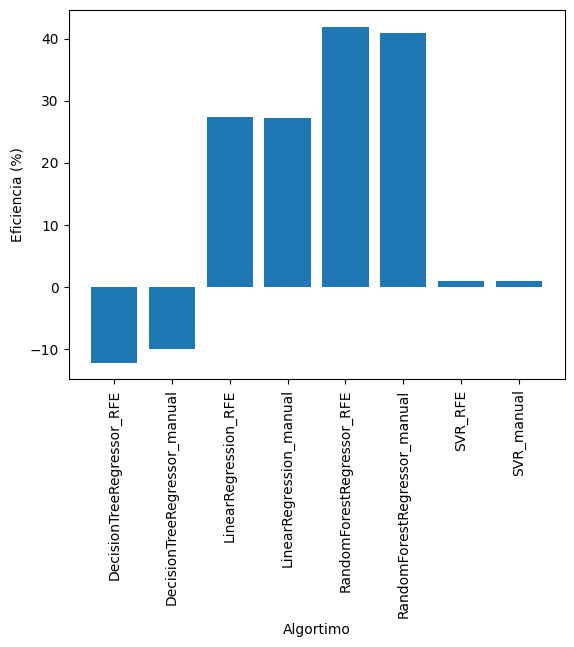

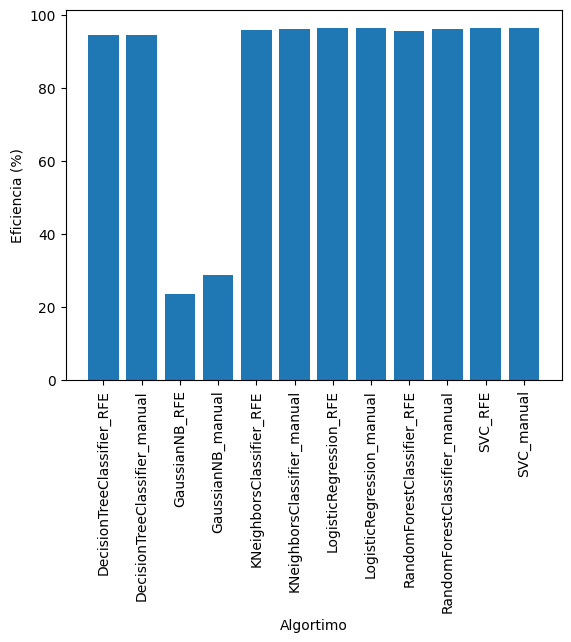

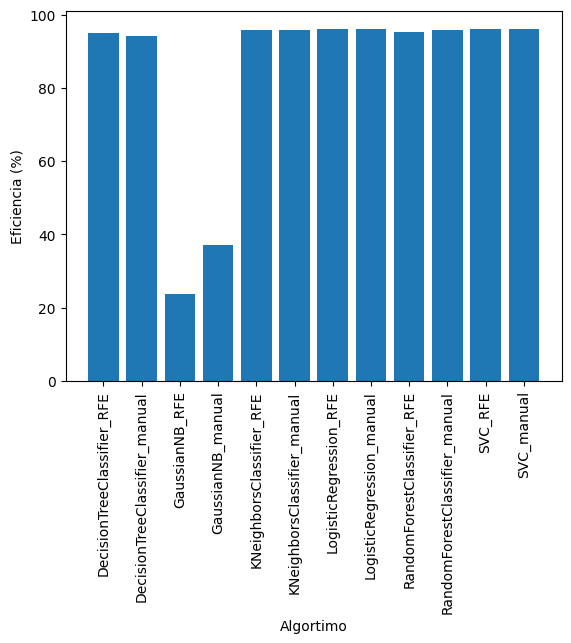

In [6]:
# Obtener las claves y los valores para el gráfico
dict_target = {
    'race_final_position' : 'la posición final de carrera', 
    'qualy_pole' : 'el ganador de la pole',
    'race_winner': 'el ganador de la carrera'
}
dict_select = {
    'auto_race':'',
    'auto_pole':'',
    'auto_winner':''
}
for target in variable_obj_models_score:
    diccionario_ordenado = dict(sorted(variable_obj_models_score[target].items(), key=lambda x: x[0]))
    keys = diccionario_ordenado.keys()
    keys = [palabra.replace('auto_race', 'RFE') for palabra in keys]
    keys = [palabra.replace('auto_winner', 'RFE') for palabra in keys]
    keys = [palabra.replace('auto_pole', 'RFE') for palabra in keys]
    values = [item[1]*100 for item in diccionario_ordenado.values()]

    # Crear el gráfico de barras
    plt.bar(keys, values)

    # # Agregar etiquetas a las barras
    for i, score in enumerate(values):
        plt.text(i, score, str(score), ha='center', va='bottom')

    # Personalizar el gráfico
    plt.xlabel('Algortimo')
    plt.ylabel('Eficiencia (%)')
    # plt.title(f'Eficiencia de los modelos para predecir {dict_target[target]}')
    plt.xticks(rotation=90)

    # Mostrar el gráfico
    plt.show()

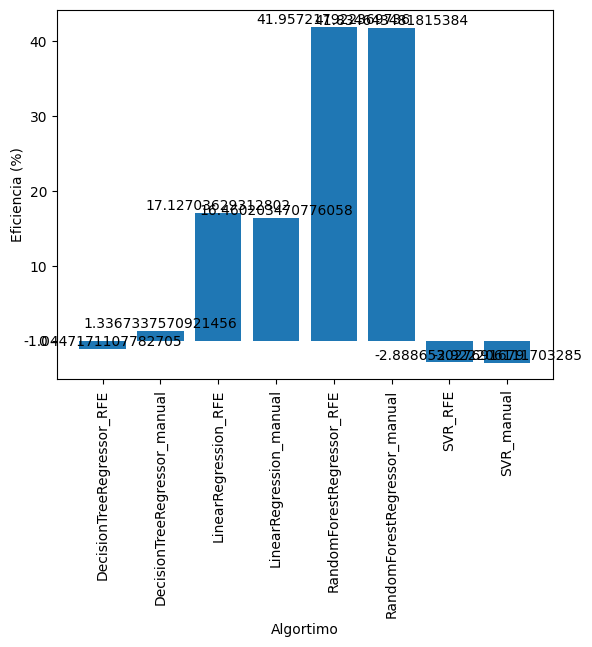

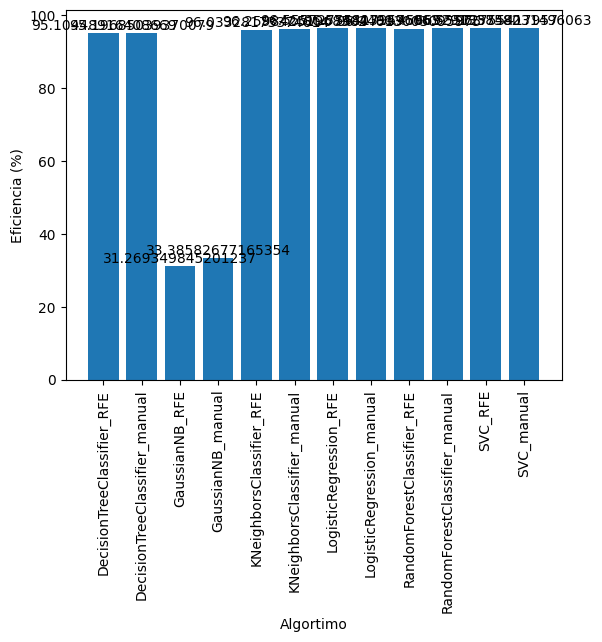

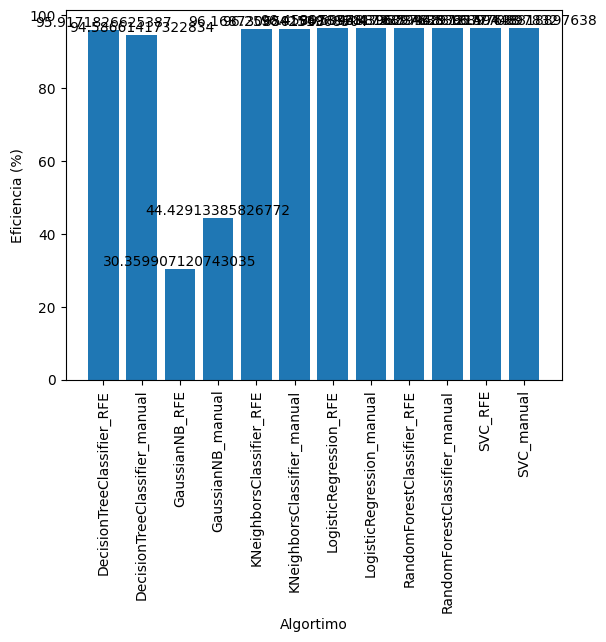

In [59]:
# Obtener las claves y los valores para el gráfico
dict_target = {
    'race_final_position' : 'la posición final de carrera', 
    'qualy_pole' : 'el ganador de la pole',
    'race_winner': 'el ganador de la carrera'
}
dict_select = {
    'auto_race':'',
    'auto_pole':'',
    'auto_winner':''
}
for target in variable_obj_models_score:
    diccionario_ordenado = dict(sorted(variable_obj_models_score[target].items(), key=lambda x: x[0]))
    keys = diccionario_ordenado.keys()
    keys = [palabra.replace('auto_race', 'RFE') for palabra in keys]
    keys = [palabra.replace('auto_winner', 'RFE') for palabra in keys]
    keys = [palabra.replace('auto_pole', 'RFE') for palabra in keys]
    values = [item[1]*100 for item in diccionario_ordenado.values()]

    # Crear el gráfico de barras
    plt.bar(keys, values)

    # Agregar etiquetas a las barras
    for i, score in enumerate(values):
        plt.text(i, score, str(score), ha='center', va='bottom')

    # Personalizar el gráfico
    plt.xlabel('Algortimo')
    plt.ylabel('Eficiencia (%)')
    # plt.title(f'Eficiencia de los modelos para predecir {dict_target[target]}')
    plt.xticks(rotation=90)

    # Mostrar el gráfico
    plt.show()

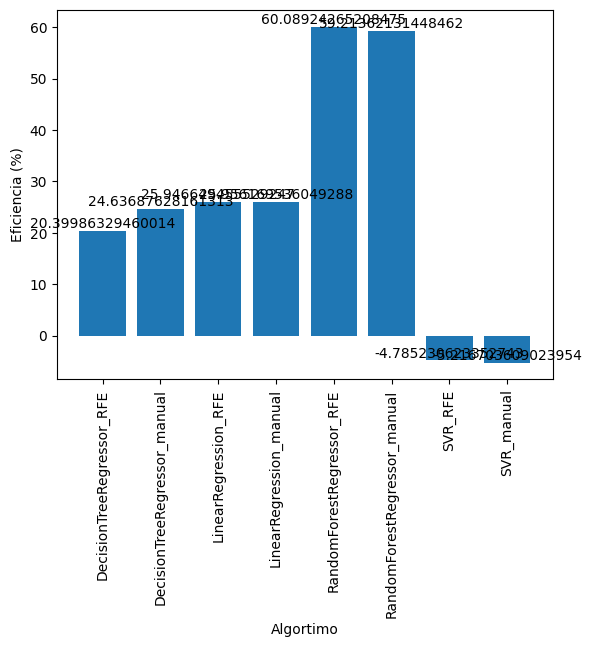

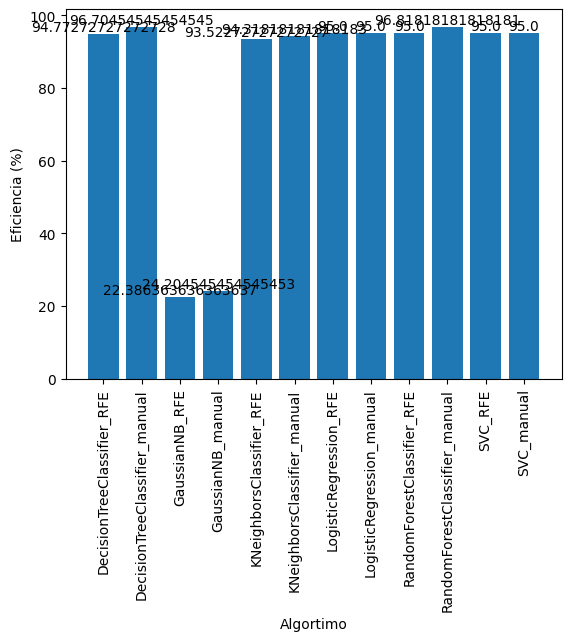

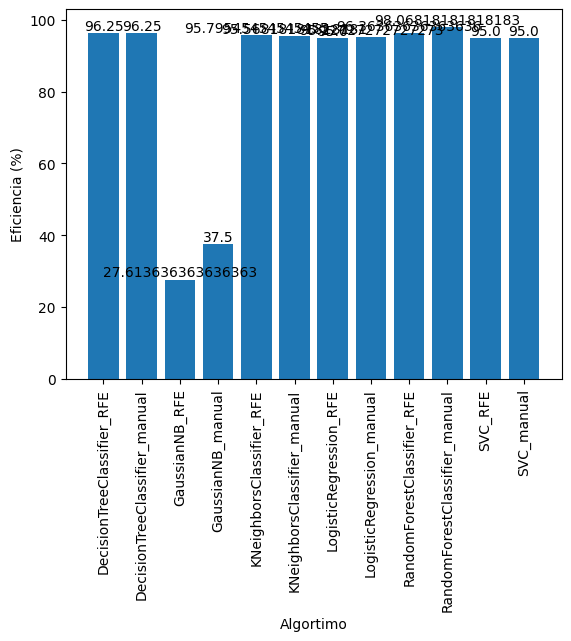

In [6]:
# Obtener las claves y los valores para el gráfico
dict_target = {
    'race_final_position' : 'la posición final de carrera', 
    'qualy_pole' : 'el ganador de la pole',
    'race_winner': 'el ganador de la carrera'
}
dict_select = {
    'auto_race':'',
    'auto_pole':'',
    'auto_winner':''
}
for target in variable_obj_models_score:
    diccionario_ordenado = dict(sorted(variable_obj_models_score[target].items(), key=lambda x: x[0]))
    keys = diccionario_ordenado.keys()
    keys = [palabra.replace('auto_race', 'RFE') for palabra in keys]
    keys = [palabra.replace('auto_winner', 'RFE') for palabra in keys]
    keys = [palabra.replace('auto_pole', 'RFE') for palabra in keys]
    values = [item[1]*100 for item in diccionario_ordenado.values()]

    # Crear el gráfico de barras
    plt.bar(keys, values)

    # Agregar etiquetas a las barras
    for i, score in enumerate(values):
        plt.text(i, score, str(score), ha='center', va='bottom')

    # Personalizar el gráfico
    plt.xlabel('Algortimo')
    plt.ylabel('Eficiencia (%)')
    # plt.title(f'Eficiencia de los modelos para predecir {dict_target[target]}')
    plt.xticks(rotation=90)

    # Mostrar el gráfico
    plt.show()

***Gráfico de tiempos de ejecución***

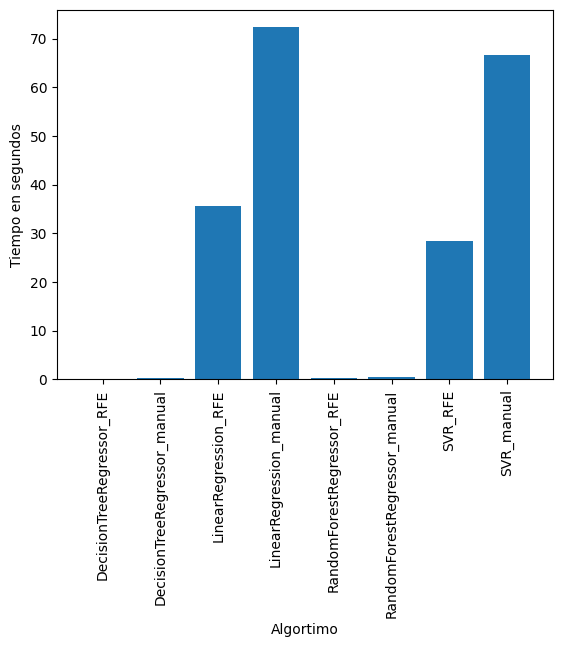

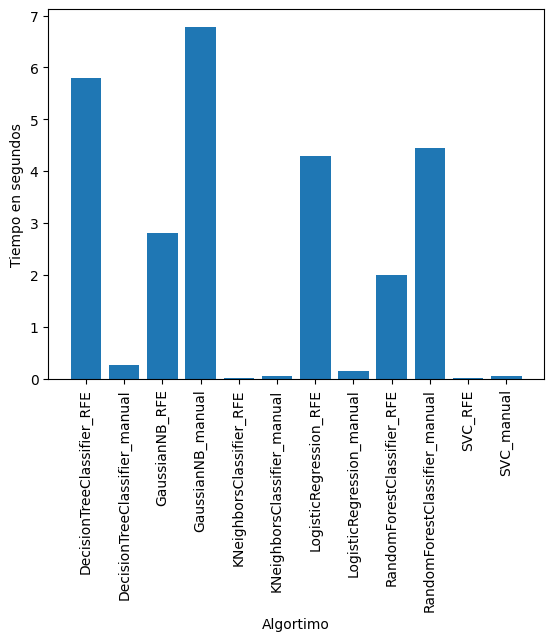

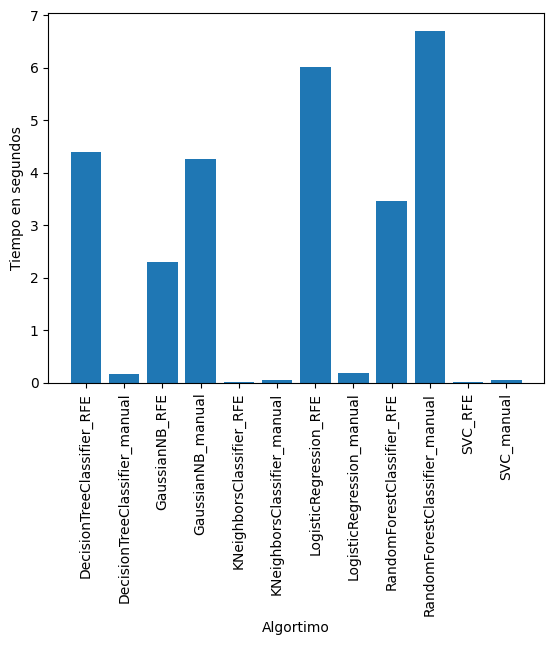

In [57]:

for target in variable_obj_models_score:
    diccionario_ordenado = dict(sorted(variable_obj_models_score[target].items(), key=lambda x: x[0]))
    keys = diccionario_ordenado.keys()
    keys = [palabra.replace('auto_race', 'RFE') for palabra in keys]
    keys = [palabra.replace('auto_winner', 'RFE') for palabra in keys]
    keys = [palabra.replace('auto_pole', 'RFE') for palabra in keys]
    values = [item[2] for item in variable_obj_models_score[target].values()]

    # Crear el gráfico de barras
    plt.bar(keys, values)

    # Personalizar el gráfico
    plt.xlabel('Algortimo')
    plt.ylabel('Tiempo en segundos')
    # plt.title(f'Tiempo de ejecución de los algoritmos para predecir {dict_target[target]}')
    plt.xticks(rotation=90)

    # Mostrar el gráfico
    plt.show()